# Introduction

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, the original features and more background information about the data cannot be provided. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/creditcardfraud/creditcard.csv


In [35]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [36]:
data=pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [37]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [38]:
data.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [39]:
data.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

So, data has no null values and it has all numerical features.

In [40]:
data.shape

(284807, 31)

In [41]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

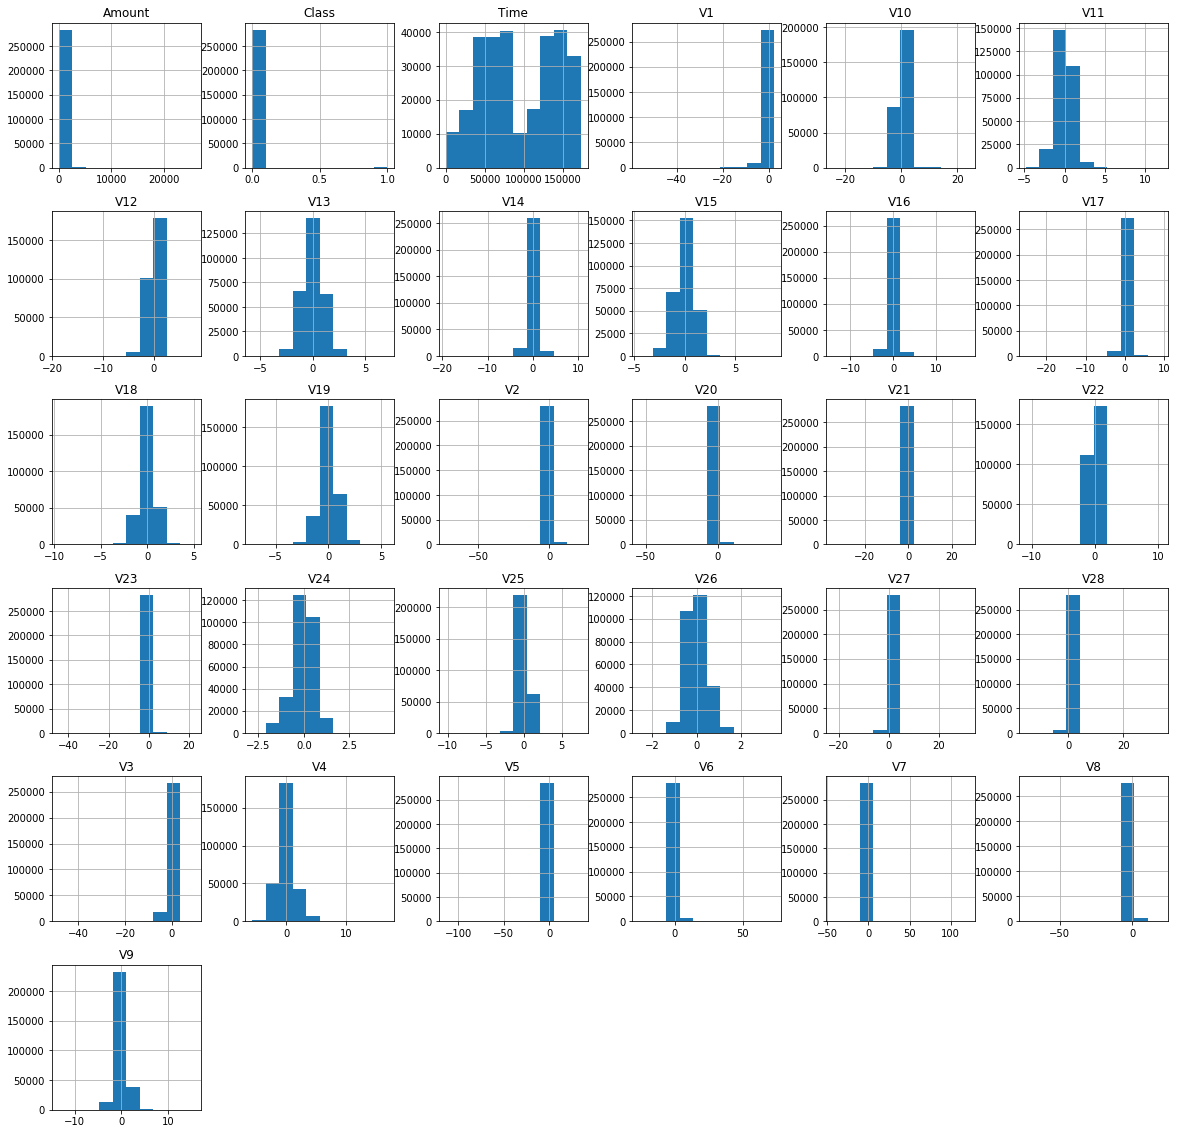

In [42]:
data.hist(figsize=(20,20))
plt.show()

Data is not widely spreaded except time. Even the transaction amount is not that large.

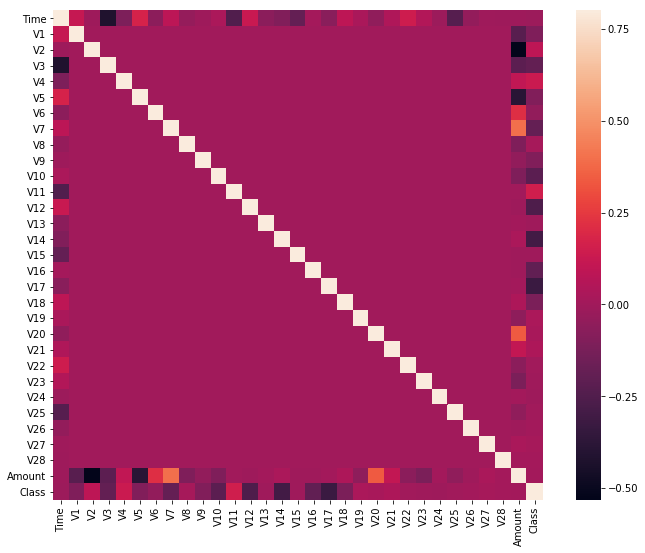

In [43]:
correlation_matrix = data.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

None of the features are closely related except time, amount and class with few of the features.

In [44]:
print("Percentage of fraud transactions = ",data['Class'].value_counts()[1]/(data['Class'].value_counts()[1]+data['Class'].value_counts()[0])*100)

Percentage of fraud transactions =  0.1727485630620034


So, our dataset is imbalanced. If we use accuracy as metric, then it will give inaccurate results. So, we will be using AUC score and Confusion Matrix.

We will try various methods to improve scores.
1. Apply ML algorithms as it is.
2. Oversampling — SMOTE
3. Undersampling — RandomUnderSampler
4. Combined Class Methods — SMOTE + ENN

# Split data into train, test, cv

In [45]:
y=data['Class']

In [46]:
data=data.drop(['Class'],axis=1)

In [62]:
train_data,test_data,y_train,y_test=train_test_split(data,y,stratify=y,test_size=0.3)
train_data,cv_data,y_train,y_cv=train_test_split(train_data,y_train,stratify=y_train,test_size=0.3)

# Applying Various Algorithms

## Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

In [50]:
train_auc = []
cv_auc = []
log_alphas=[]

parameters = {'C':[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,2.5,5]}

for i in tqdm(parameters['C']):
    lr = LogisticRegression(C=i)
    lr.fit(train_data, y_train)

    y_train_pred = lr.predict(train_data)    
    y_cv_pred = lr.predict(cv_data)
       
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


100%|██████████| 11/11 [00:42<00:00,  4.52s/it]

In [51]:
import math 
for a in tqdm(parameters['C']):
    b = math.log10(a)
    log_alphas.append(b)
print(log_alphas)


100%|██████████| 11/11 [00:00<00:00, 13951.42it/s]

[-4.0, -3.3010299956639813, -3.0, -2.3010299956639813, -2.0, -1.3010299956639813, -1.0, -0.3010299956639812, 0.0, 0.3979400086720376, 0.6989700043360189]


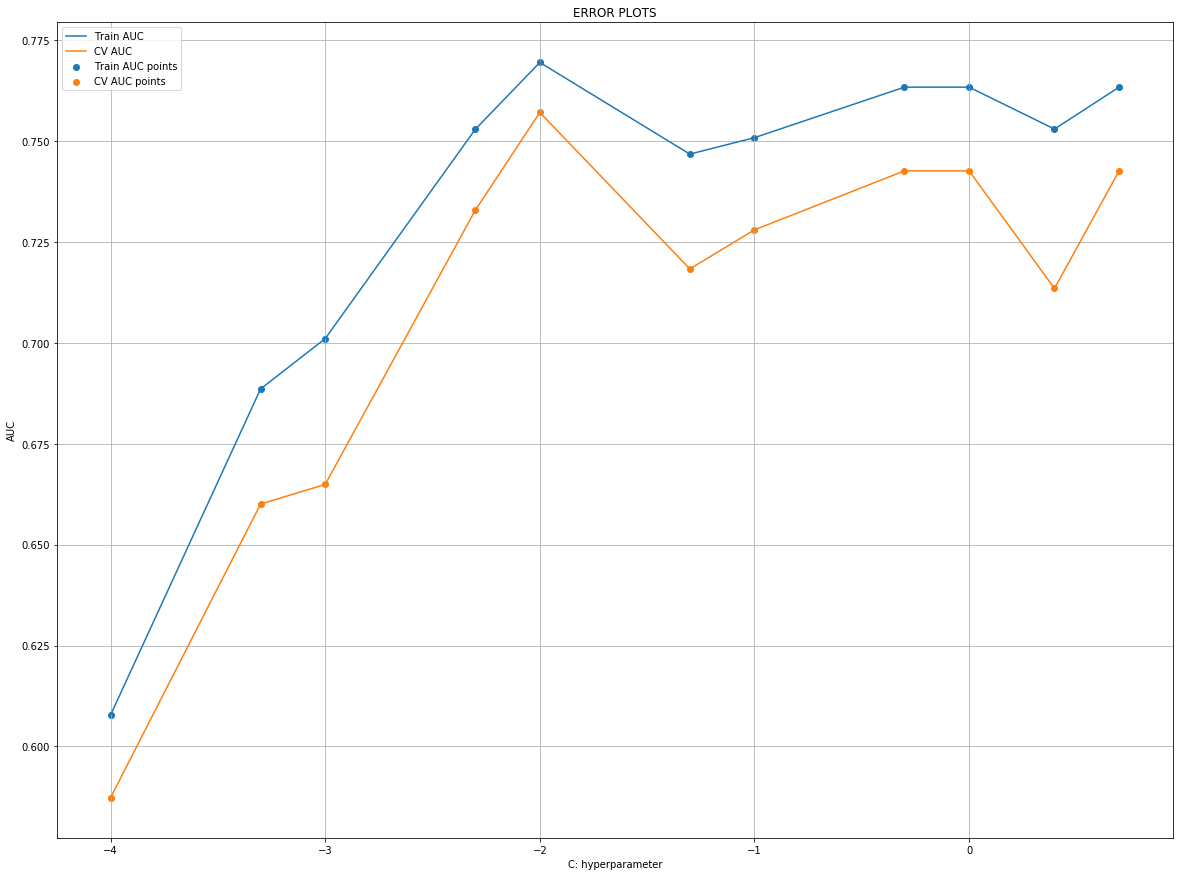

In [52]:
plt.figure(figsize=(20,15))
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [53]:
best_alpha=10**-2
lr = LogisticRegression(C=best_alpha)
lr.fit(train_data, y_train)
y_train_pred = lr.predict(train_data)    
y_test_pred = lr.predict(test_data)

In [54]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

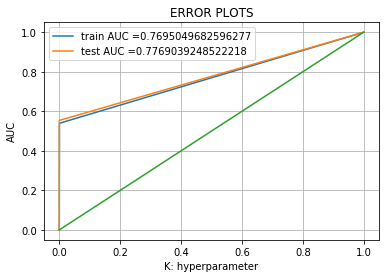

In [55]:
x=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(x,x)
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

# Upsampling Using SMOTE

In [56]:
from imblearn.over_sampling import SMOTE

In [63]:
smt = SMOTE()
train_data, y_train = smt.fit_sample(train_data, y_train)

In [65]:
train_auc = []
cv_auc = []
log_alphas=[]

parameters = {'C':[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,2.5,5]}

for i in tqdm(parameters['C']):
    lr = LogisticRegression(C=i)
    lr.fit(train_data, y_train)

    y_train_pred = lr.predict(train_data)    
    y_cv_pred = lr.predict(cv_data)
       
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


100%|██████████| 11/11 [01:00<00:00,  5.48s/it]

In [66]:
import math 
for a in tqdm(parameters['C']):
    b = math.log10(a)
    log_alphas.append(b)
print(log_alphas)


100%|██████████| 11/11 [00:00<00:00, 12238.02it/s]

[-4.0, -3.3010299956639813, -3.0, -2.3010299956639813, -2.0, -1.3010299956639813, -1.0, -0.3010299956639812, 0.0, 0.3979400086720376, 0.6989700043360189]


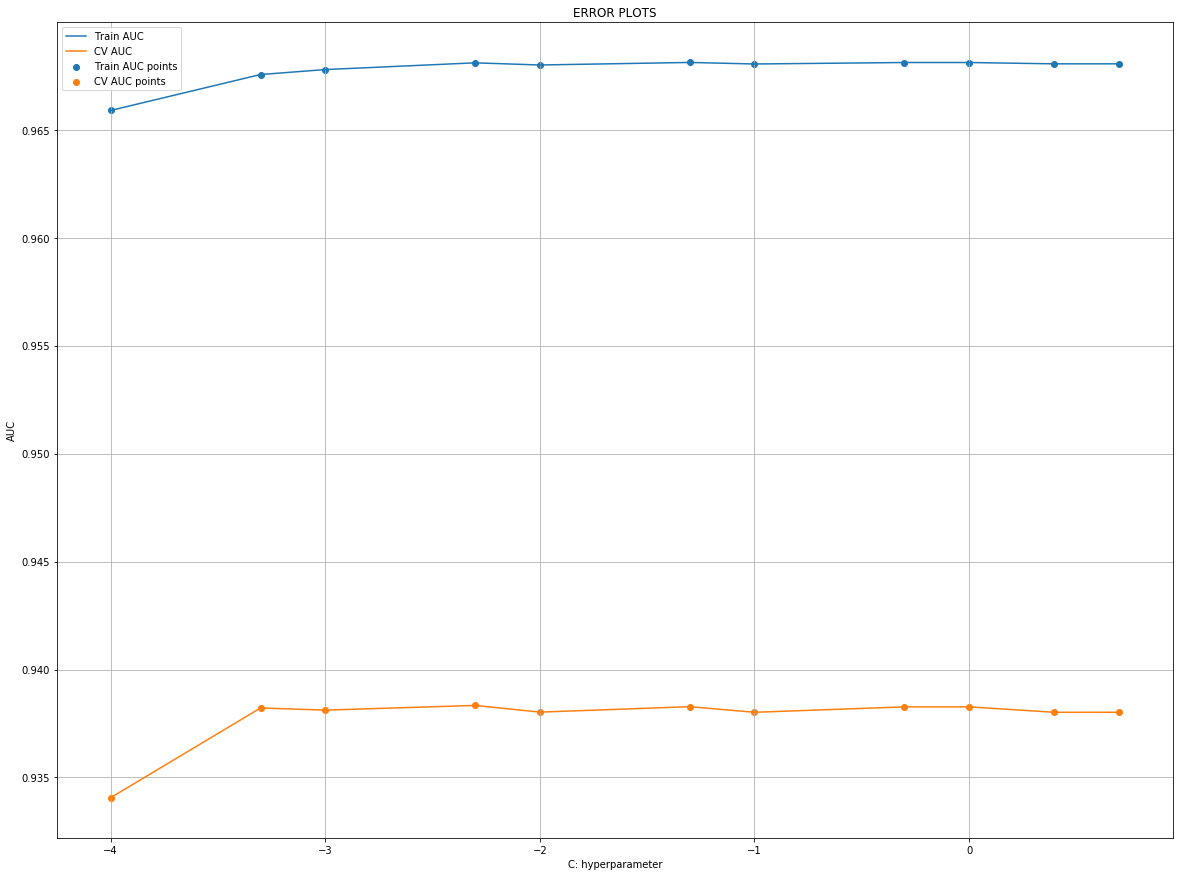

In [67]:
plt.figure(figsize=(20,15))
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [68]:
best_alpha=10**-3.20
lr = LogisticRegression(C=best_alpha)
lr.fit(train_data, y_train)
y_train_pred = lr.predict(train_data)    
y_test_pred = lr.predict(test_data)

In [69]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

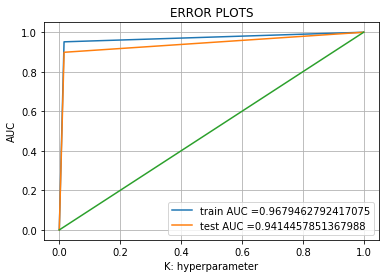

In [70]:
x=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(x,x)
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()